In [1]:
import os
import numpy as np
import pandas as pd
import music21 as m21
from typing import List
from itertools import product
from collections import defaultdict
from sklearn.externals import joblib
from scipy.sparse import dok_matrix, vstack
from easy_ml.tools.util import download_from_gcs

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt

In [4]:
DATA_DIR = '/home/jovyan/persistent_data/data/classical-corpus/'

In [4]:
download_from_gcs(bucket_name='midi-files',
                  prefix='collections/classical-collection/k_collection/',
                  local_fs_loc=DATA_DIR)

In [6]:
midi_files = os.listdir(DATA_DIR)

## Note Encoding Schemes
* m-Bar Encodings: Similar to a term-document frequency matrix. Encode a multinomial distribution of notes over a sequence of m measures
    * Parts together in their
    * Pitches encoded as their numerical value, rests encoded as 0
    * Pitches encoded as their numerical value, no rests
* m-bar time series: Each part is an m-bar time series over 127 notes
    * Pitches encoded as their numerical value, rests encoded as 0 (only sensible way in this scenario)
* n-Note Encodings: Similar to n-grams; sequences of m measures will be encoded into $127^n$ features
    * Pitches encoded as their numerical value, rests encoded as 0
    * Pitches encoded as their numerical value, no rests
* n-Note Pitch-Difference Encodings: Similar to above, but instead of mapping each feature distinct pitch as a feature, the difference between subsequent pitches will be analyzed to try to capture melodic patterns
    * Pitches encoded as their numerical value, rests encoded as 0? (probably not sensible in this scenario)
    * Pitches encoded as their numerical value, no rests
    * Do we add durations (like in A Comparison of Statistical Approaches to Symbolic Genre Recognition)

**NOTE** Generate the full feature set by iterating through the entire scale of notes

### n-Note Encodings

In [334]:
# TODO: coansistency in variable namings (e.g. path_ vs path)
# TODO: docstrings
# TODO: save additional metadata?

In [5]:
def window_gen(sequence, n):
    windowed_iterator = []
    low = 0
    high = n
    for note in sequence:
        window = sequence[low:high]
        if len(window) < n:
            break
        low += 1
        high += 1
        yield tuple(window)

In [137]:
class MidiFeatureCorpus(object):
    def __init__(self, path: str):
        self.path = path
        self.files_ = self._depth_first_midi_search(self.path)
        self.note_sequence_set = self.initialize_note_sequence_set()
        self.sparse_matrix = dok_matrix((len(self.files_),
                                         len(self.note_sequence_set)),
                                        dtype=np.float32)
    
    def _depth_first_midi_search(self, path: str) -> List[str]:
        files_out = []
        paths = os.listdir(path)
        for p in paths:
            full_subpath = path + "/" + p
            try:
                dir_contents = os.listdir(full_subpath)
                dfs_results = self._depth_first_midi_search(full_subpath)
                for file in dfs_results:
                    files_out.append(file)
            except NotADirectoryError:
                if full_subpath.endswith(".mid"):
                    files_out.append(full_subpath)
        return files_out
    
    @staticmethod
    def initialize_note_sequence_set():
        notes = []
        for i in range(128):
            note = m21.note.Note(i)
            notes.append(note.nameWithOctave)
        
        note_sequences = []
        for combo in product(notes, notes):
            note_sequences.append(combo[0] + "|" + combo[1])
        return note_sequences
    
    @staticmethod
    def get_n_note_sequence(part: m21.stream.Part,
                            window_size: int = 2):
        just_notes = part.recurse().notes \
            .getElementsNotOfClass(m21.chord.Chord)
        n_note_sequences = []
        for note_seq in window_gen(just_notes, window_size):
            n_note_sequences.append("|".join([note.nameWithOctave for note in note_seq]))
        return n_note_sequences
    
    @staticmethod
    def sequence_encoder(seq: List[str]):
        d = defaultdict(float)
        for entry in seq:
            d[entry] += 1.
        return d
    
    def _parse_file_as_sequence(self, file_name):
        parsed_file = m21.converter.parse(file_name)
        return self.get_n_note_sequence(parsed_file)
        
        
    def parse_corpus(self):
        for i, file in enumerate(self.files_):
            try:
                sequence = self._parse_file_as_sequence(file)
                encoded_sequence = self.sequence_encoder(sequence)
                for (seq, count) in encoded_sequence.items():
                    j = self.note_sequence_set.index(seq)
                    self.sparse_matrix[i, j] = count
            except m21.midi.MidiException:
                continue

In [138]:
import pdb

In [142]:
class LabeledCorpusSet(object):
    def __init__(self, path: str):
        self.path_ = path
        self.corpus_name_list_ = os.listdir(self.path_)
        self.corpus_labels = []
        self.corpus_list_ = []
        matrix_shape = (0, len(MidiFeatureCorpus.initialize_note_sequence_set()))
        self.sparse_matrix = dok_matrix(matrix_shape)
        self.parsed_ = False
        
    def parse_corpus_set(self):
        """
        Iterates through the files in the corpus. Will ignore directory structure within
        a corpus (e.g. if cantatas and sonatas are in different files)
        """
        matrix_set = []
        for corpus_name in self.corpus_name_list_:
            if corpus_name not in ["satie", "albeniz"]:
                continue
            file_path = self.path_ + corpus_name
            print("reading from {}".format(file_path))
            corpus = MidiFeatureCorpus(file_path)
            corpus.parse_corpus()
            self.corpus_list_.append(corpus)
            for label in range(corpus.sparse_matrix.shape[0]):
                self.corpus_labels.append(corpus_name)
            matrix_set.append(corpus.sparse_matrix)
        self.sparse_matrix = vstack(matrix_set)
        self.parsed_ = True

In [143]:
labeled_corpus = LabeledCorpusSet(DATA_DIR)

In [144]:
labeled_corpus.parse_corpus_set()

reading from /home/jovyan/persistent_data/data/classical-corpus/satie
reading from /home/jovyan/persistent_data/data/classical-corpus/albeniz


KeyboardInterrupt: 

In [130]:
labeled_corpus.corpus_labels

[]

In [131]:
labeled_corpus.corpus_list_

[]

In [ ]:
labeled_corpus.sparse_matrix

In [ ]:
joblib.dump(labeled_corpus.sparse_matrix,
            '/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl',
           compress=5)

In [203]:
tsne = TSNE(n_components=2, random_state=0)
tsne.fit(dense_mozart)

TSNE(angle=0.5, early_exaggeration=4.0, init='random', learning_rate=1000.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=30,
   perplexity=30.0, random_state=0, verbose=0)

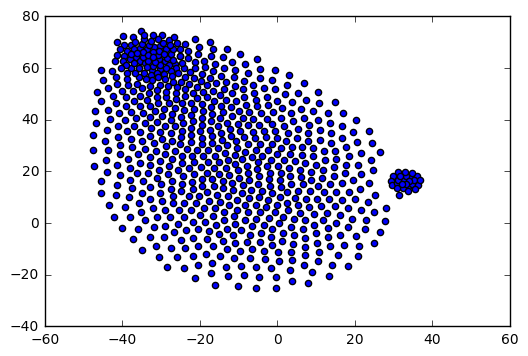

In [214]:
plt.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1])